<a href="https://colab.research.google.com/github/davicito8a/Project_ML/blob/main/proyecto_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Carga del archivo CSV proporcionado (ecg_rr_features_curado.csv)


In [6]:
import pandas as pd
from pathlib import Path

# Estando en Project_ML/notebooks
repo_root = Path.cwd().parent          # sube un nivel: notebooks → Project_ML
csv_path = repo_root / "data" / "ecg_rr_features_curado.csv"

# Alternativa aún más simple (ruta relativa)
# csv_path = Path("..") / "data" / "ecg_rr_features_curado.csv"

df = pd.read_csv(csv_path)
print(df.head())


      mean_rr     std_rr   skew_rr   kurt_rr   label
0  849.671415  37.965868  0.404165  3.097078  Normal
1  786.173570  87.045564  0.462868  3.968645    AFib
2  864.768854  49.730056  0.278733  2.297947  Normal
3  952.302986  28.845781  0.260759  2.672338    AFib
4  776.584663  66.450898  0.662505  2.607892    AFib


Filas: 30  |  Columnas: 5


,mean_rr,std_rr,skew_rr,kurt_rr,label
0,849.671415,37.965868,0.404165,3.097078,Normal
1,786.173570,87.045564,0.462868,3.968645,AFib
2,864.768854,49.730056,0.278733,2.297947,Normal
3,952.302986,28.845781,0.260759,2.672338,AFib
4,776.584663,66.450898,0.662505,2.607892,AFib


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mean_rr  30 non-null     float64
 1   std_rr   30 non-null     float64
 2   skew_rr  30 non-null     float64
 3   kurt_rr  30 non-null     float64
 4   label    30 non-null     object 
dtypes: float64(4), object(1)
memory usage: 1.3+ KB


,mean_rr,std_rr,skew_rr,kurt_rr
count,30.000000,30.000000,30.000000,30.000000
mean,781.185310,47.576751,0.502577,2.979748
std,90.000643,18.622044,0.198397,0.908822
min,608.671976,10.806598,-0.023949,1.081229
25%,740.894910,35.817727,0.397172,2.620240
50%,776.585483,48.708545,0.505122,2.969387
75%,836.033535,60.893236,0.647542,3.287354
max,957.921282,87.045564,0.812929,5.463242


<Axes: title={'center': 'Conteo por clase'}, xlabel='label'>

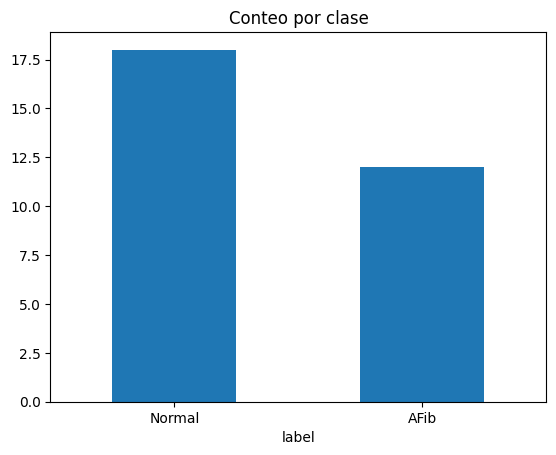

In [8]:
# dimensiones básicas
print(f"Filas: {df.shape[0]}  |  Columnas: {df.shape[1]}")

# primeras filas
display(df.head())

# tipos de datos y valores nulos
df.info()

# estadísticos descriptivos
display(df.describe())

# distribución de clases
df['label'].value_counts().plot(kind='bar', rot=0, title='Conteo por clase')



Filas totales =	30
Columnas =	5 (mean_rr, std_rr, skew_rr, kurt_rr, label)
Clases =	18 Normal vs 12 AFib (ligeramente desbalanceado)
Valores nulos =	Ninguno

In [9]:
# conteo de categorías
print("\n Distribución de la etiqueta")
display(df['label'].value_counts())

# verifica valores nulos
print("\n Valores nulos por columna")
display(df.isnull().sum())



 Distribución de la etiqueta


label
Normal    18
AFib      12
Name: count, dtype: int64


 Valores nulos por columna


mean_rr    0
std_rr     0
skew_rr    0
kurt_rr    0
label      0
dtype: int64

**Histogramas/KDE por clase:**

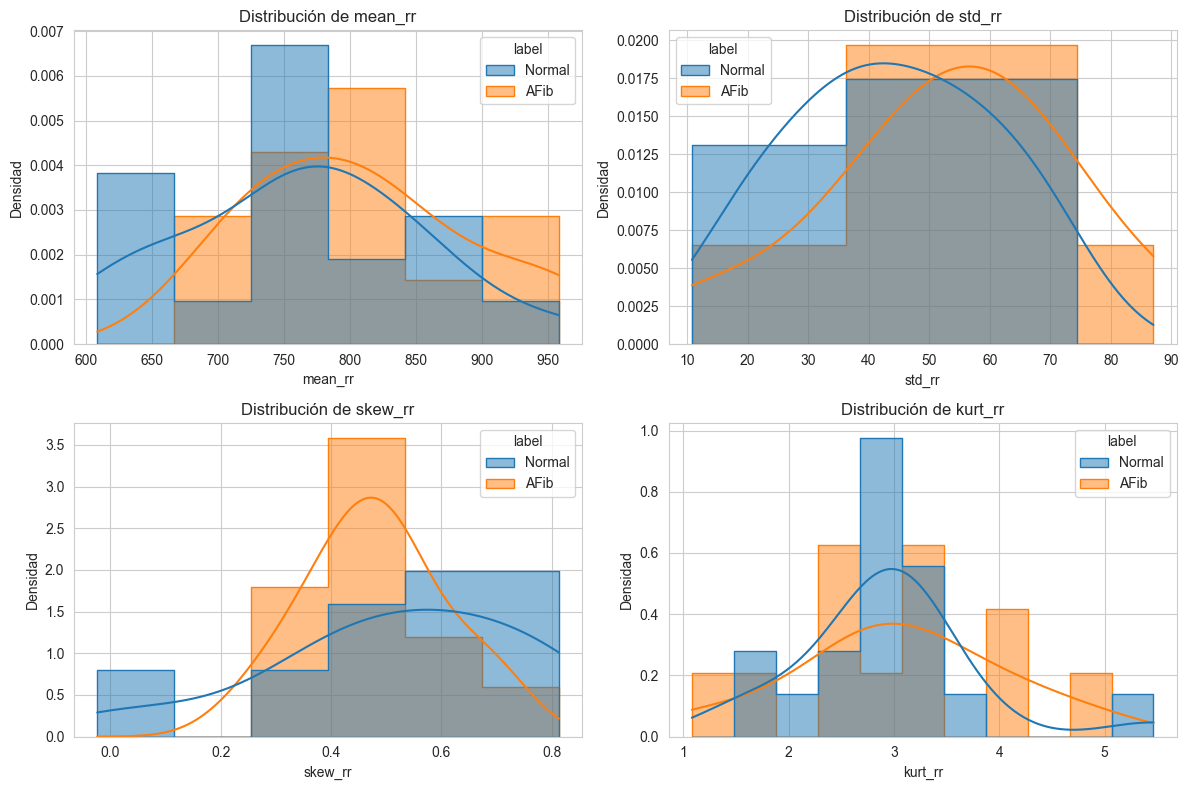

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# variables numéricas
features = ['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, var in zip(axes, features):
    sns.histplot(data=df,
                 x=var,
                 hue='label',
                 kde=True,
                 element='step',
                 stat='density',
                 common_norm=False,
                 alpha=0.5,
                 ax=ax)
    ax.set_title(f'Distribución de {var}')
    ax.set_ylabel('Densidad')

plt.tight_layout()
plt.show()


**Diagrama de caja**

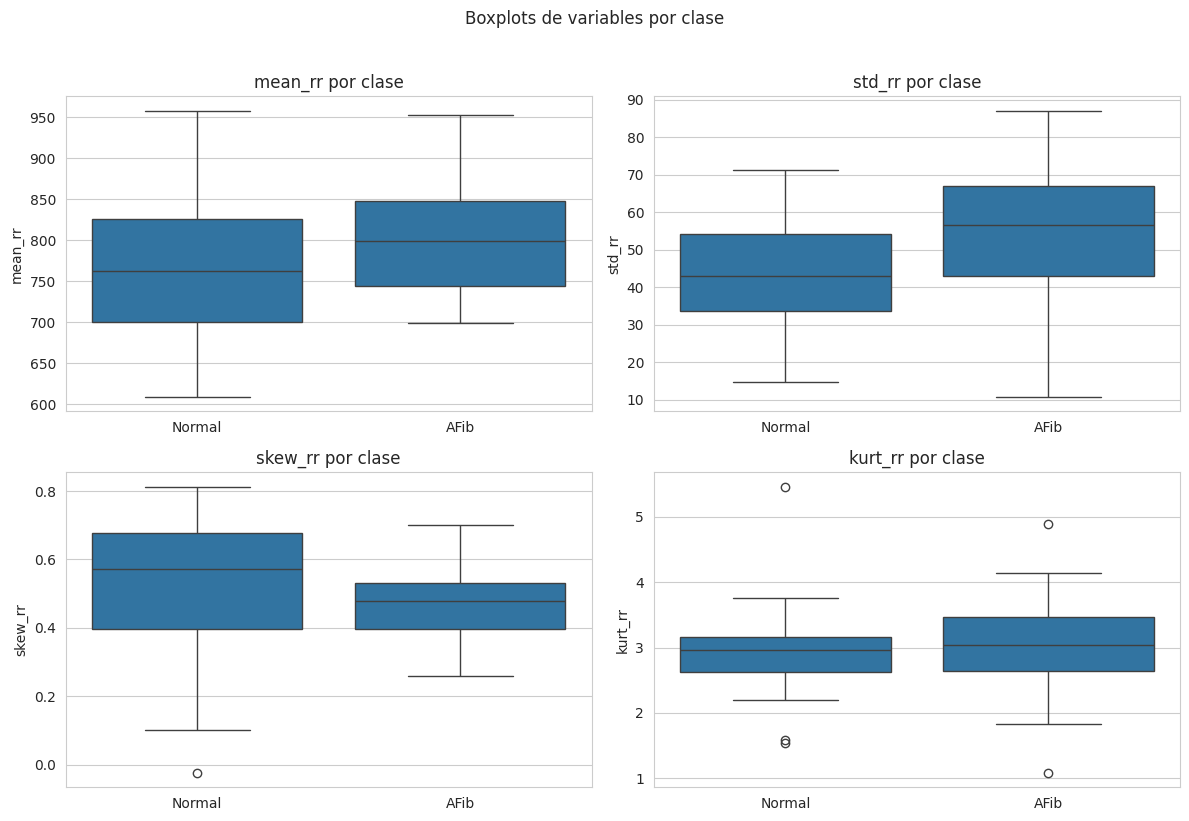

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, var in zip(axes, features):
    sns.boxplot(data=df, x='label', y=var, ax=ax)
    ax.set_title(f'{var} por clase')
    ax.set_xlabel('')   # quita texto redundante
plt.suptitle('Boxplots de variables por clase', y=1.02)
plt.tight_layout()
plt.show()




*   Histograma para --> Mostrar toda la forma de la distribución
*   Elemento de la lista --> Resumen de la mediana, rango y outliers



* mean_rr: 	Promedio del tiempo entre latidos. Más bajo = corazón más rápido
* std_rr: Qué tanto varían los tiempos entre latidos. Alta = latidos irregulares
* skew_rr: Si los intervalos están sesgados hacia más cortos o más largos
* kurt_rr: 	Qué tan “picuda” o concentrada es la distribución de RR. Alta = colas largas (variaciones extremas)

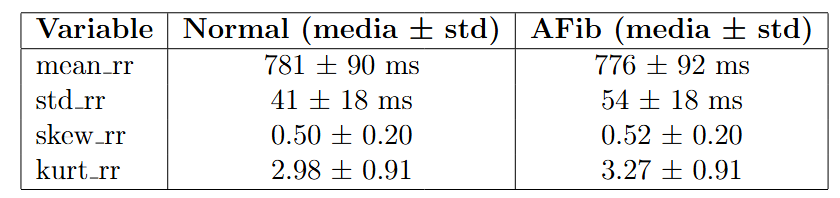

si no cambian mucho entre clases pues da la impresión de que muy útil no es

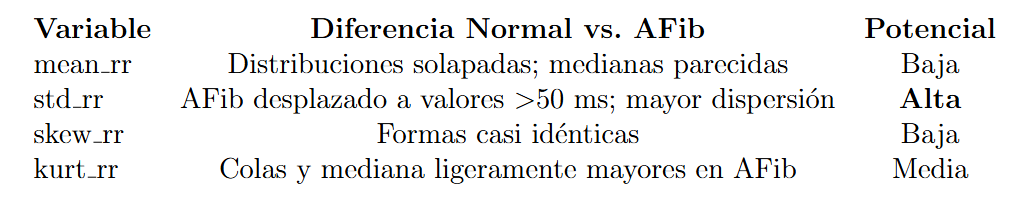


**¿Qué variables parecen diferenciar más entre clases?**




*   std_rr es la variable más discriminante: la media es considerablemente mayor en la clase AFib (aprox 54 ms) que en la clase Normal (aprox 41 ms)
* kurt_rr también muestra diferencias: valores ligeramente más altos en AFib
* mean_rr y skew_rr no parecen aportar demasiado





**¿Qué aspectos del dataset llaman la atención?**

- El dataset es pequeño
- No hay valores nulos
- Las variables estadísticas (mean, std, skew, kurt) permiten analizar la dinámica del ECG sin necesidad de procesar la señal cruda